Dataset is download from: https://huggingface.co/datasets/harpomaxx/dga-detection

In [1]:
!pip install tldextract

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import pandas as pd
from nltk import ngrams
import tldextract as tld
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder


from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

import time


In [4]:
torch.backends.cudnn.benchmark = True  

In [5]:
class DomainExtractor:
  def __init__(self, extra_suffixes=None):
    self.extract = tld.TLDExtract(
        extra_suffixes=extra_suffixes,
        include_psl_private_domains=False
    )

  def extract_registered_domain(self, url):
    extracted = self.extract(url)
    if extracted.domain == 'www':
      return url
    return extracted.domain

def generate_n_grams(text, n, right_pad_symbol='<PAD>'):
    return list(ngrams(text, n, pad_right=True, right_pad_symbol='<PAD>'))

In [6]:
path = "dataset/dga1.0.csv"
df = pd.read_csv(path)

In [7]:
# we need to clean the data first
df['default/domain'] = df['default/domain'].astype(str) # change the type to string
df['default/domain'] = df['default/domain'].apply(lambda x: x[2:-1] if x.startswith("b'") and x.endswith("'") else x) # remove the byte representation
df['default/label'] = df['default/label'].astype(str).apply(lambda x: x[2:-1] if x.startswith("b'") and x.endswith("'") else x) # doing same things to label

# seperate a new class of dictionary based dga
dictionary_type = ['dga.beebone', 'dga.corebot', 'dga.matsnu', 'dga.suppobox'] # these are the lables that I found is following dictionary algorithm
for stype in dictionary_type:
  df.loc[df['default/label'] == stype, 'default/class'] = 2

print(df[df.iloc[:, 2] == 2])

                              default/domain default/label  default/class
22270                      villagemuscle.com    dga.matsnu              2
26064                         visitallow.net  dga.suppobox              2
26128                         visitbuild.net  dga.suppobox              2
26144                          visitcome.net  dga.suppobox              2
26159                          visitdeal.net  dga.suppobox              2
...                                      ...           ...            ...
2715323      squarewritedragdishbuilding.com    dga.matsnu              2
2715324        collarestablishpenbikefix.com    dga.matsnu              2
2715325         welcomeexploreboneremain.com    dga.matsnu              2
2715326        purposepenresistbellprint.com    dga.matsnu              2
2715327  averagesuggestpaintspotexchange.com    dga.matsnu              2

[109362 rows x 3 columns]


In [8]:
# extract second level domain name
# suffixes that wasn't recorded in the original suffix list
my_suffixes = [
    "co.vu",
    "co.ba",
    "co.gr",
    "co.cu",
    "co.cc",
    "co.tv",
    "co.nf",
    "co.nr",
    "co.ee",
    "co.nl",
    "co.pl",
    "co.ua",
]
# append my_suffixes to the original suffix list
domain_extractor = DomainExtractor(extra_suffixes = my_suffixes)

In [9]:
# if the test case have no problem, we will start extract the second-level domain out
df['second-level domain'] = df['default/domain'].apply(domain_extractor.extract_registered_domain)
df = df.loc[~df['second-level domain'].str.contains('\.')]
# generate n-gram
df['grams'] = df['second-level domain'].apply(lambda x: generate_n_grams(x, n=3))

In [10]:
df.head()

,default/domain,default/label,default/class,second-level domain,grams
0,vashikarana.net,normal.alexa,0,vashikarana,"[(v, a, s), (a, s, h), (s, h, i), (h, i, k), (..."
1,vashikaranandblackmagicforlove.blogspot.in,normal.alexa,0,blogspot,"[(b, l, o), (l, o, g), (o, g, s), (g, s, p), (..."
2,vashikaranastrologerguru.com,normal.alexa,0,vashikaranastrologerguru,"[(v, a, s), (a, s, h), (s, h, i), (h, i, k), (..."
3,vashikaranblackmagicindia.com,normal.alexa,0,vashikaranblackmagicindia,"[(v, a, s), (a, s, h), (s, h, i), (h, i, k), (..."
4,vashikarangod.com,normal.alexa,0,vashikarangod,"[(v, a, s), (a, s, h), (s, h, i), (h, i, k), (..."


In [11]:
# tokenization - optimized version
all_grams = {char for gram in df['grams'] for char in gram}
all_grams = list(all_grams)

vocab = {char: idx for idx, char in enumerate(all_grams, start=1)}
vocab['<PAD>'] = 0

def encode_grams(grams, vocab):
    return [vocab[char] for char in grams]

df['encoded_grams'] = df['grams'].apply(lambda grams: encode_grams(grams, vocab))

max_len = 40

def pad_sequence(sequence, max_len, pad_value=0):
    return sequence[:max_len] + [pad_value] * max(0, max_len - len(sequence))

df['padded_grams'] = df['encoded_grams'].apply(lambda seq: pad_sequence(seq, max_len))

def create_mask(seqs, pad_value=0):
    return [[1 if token != pad_value else 0 for token in seq] for seq in seqs]

mask = create_mask(df['padded_grams'].values.tolist())

In [12]:
class_2_sample = df[df['default/class'] == 2].sample(n=100000, random_state=42)
class_1_sample = df[df['default/class'] == 1].sample(n=100000, random_state=42)
class_0_sample = df[df['default/class'] == 0].sample(n=100000, random_state=42)
sample_df = pd.concat([class_2_sample, class_1_sample, class_0_sample]).sample(frac=1, random_state=42).reset_index(drop=True)


In [13]:
len(sample_df)/len(df)
# which is around 10% of data

0.10279651053818428

In [14]:
print(len(sample_df[sample_df['default/class'] == 2]))
print(len(sample_df[sample_df['default/class'] == 1]))
print(len(sample_df[sample_df['default/class'] == 0]))

100000
100000
100000


In [15]:
# word embedding layer
class InputEmbeddings(nn.Module):

  def __init__(self, d_model:int, vocab_size: int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    # the embedding model we will use
    self.embedding = nn.Embedding(vocab_size, d_model)

  # when there is any data inputted to the instance it will call this function.
  def forward(self,x):
    return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    # Create a matrix of shape(seq_len, d_model)
    pe = torch.zeros(seq_len, d_model) # torch.zeors create a tensor that all zero
    # Create a vector of shape
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (Seq_Len, 1)
    # this is quite different from the forumla I know
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    # Apply the sin encoding to even number
    pe[:, 0::2] = torch.sin(position * div_term)
    # Apply the cos encoding to odd number
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)

    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

class LayerNormalization(nn.Module):
  def __init__(self, eps:float = 10**-6):
    super().__init__()
    self.eps = eps  # this is a constant
    self.alpha = nn.Parameter(torch.ones(1)) # nn.Parameter means it is tranable
    self.bias = nn.Parameter(torch.zeros(1))
  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim= -1, keepdim= True)
    return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int, d_ff:int, dropout:float) -> None:
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff) # weighting1 and bias1
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model) # weighting2 and bias2

  def forward(self, x):
    #so we first let the input x go throgh linear_1, then a relu activation function, moreover dropout and go linear_2.
    return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class MultiHeadAttentionBlock(nn.Module):

  def __init__(self, d_model: int, h: int, dropout: float) ->None:
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, "d_model need to be divisible by h"

    self.d_k = d_model // h
    self.w_q = nn.Linear(d_model, d_model) # wq
    self.w_k = nn.Linear(d_model, d_model) # wk
    self.w_v = nn.Linear(d_model, d_model) # wv

    self.w_o = nn.Linear(d_model, d_model) # wo
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
    d_k = query.shape[-1]

    # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
    attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        # mask size
        attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

    attention_scores = attention_scores.softmax(dim=-1)

    if dropout is not None:
        attention_scores = dropout(attention_scores)

    return (attention_scores @ value), attention_scores


  def forward(self, q, k, v, mask):
    # input the word to weighting layer
    query = self.w_q(q)
    key = self.w_k(k)
    value = self.w_v(v)

    # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

    # matching the attention score diamention
    if mask is not None:
        mask = mask.unsqueeze(1).unsqueeze(1)  # adding 2 new diamention in order to let it fit with the attention score

    x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

    # (batch, h, seq_len, d_k) --> (batch, seq_len, d_model)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

    return self.w_o(x)


class ResidualConnection(nn.Module):

  def __init__(self, dropout: float) -> None:
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

class EncoderBlock(nn.Module):

  def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self, x, src_mask):
    # in the init method it construct 2 layers of #residual_connections
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
    x = self.residual_connections[1](x, self.feed_forward_block)
    return x

class Encoder(nn.Module):

  def __init__(self, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
    x = self.residual_connections[2](x, self.feed_forward_block)
    return x

class Decoder(nn.Module):

  def __init__(self, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
      for layer in self.layers:
        x = layer(x, encoder_output, src_mask, tgt_mask)
      return self.norm(x)

class ProjectionLayer(nn.Module):

  def __init__(self, d_model: int, vocab_size: int) -> None:
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
    return torch.log_softmax(self.proj(x), dim = -1)

class DGA_Dector_V1_2(nn.Module):
  def __init__(self, vocab_size: int, d_model: int, N: int, h: int, d_ff: int, max_len: int, num_classes: int = 3, dropout: float = 0.1):  # num_classes = 3
    super().__init__()

    # Embedding layer
    self.src_embed = InputEmbeddings(d_model, vocab_size)

    # Positional encoding
    self.src_pos = PositionalEncoding(d_model, max_len, dropout)

    # Create encoder blocks
    encoder_blocks = []
    for _ in range(N):
        self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    # Encoder
    self.encoder = Encoder(nn.ModuleList(encoder_blocks))

    # Global Average Pooling, ReLU, Fully Connected Layer
    self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
    self.relu = nn.ReLU()                          # ReLU activation
    self.fc = nn.Linear(d_model, num_classes)      # Fully Connected Layer

  def forward(self, src, src_mask):
    # Embedding and positional encoding
    src = self.src_embed(src)
    src = self.src_pos(src)

    # Pass through the encoder
    encoder_output = self.encoder(src, src_mask)  # Encoder: (batch_size, seq_len, d_model)

    # Global Average Pooling: (batch_size, d_model)
    pooled_output = self.global_avg_pool(encoder_output.transpose(1, 2)).squeeze(-1)

    # ReLU and Fully Connected Layer
    x = self.relu(pooled_output)
    x = self.fc(x)  # Output logits of shape (batch_size, num_classes)

    return x



In [16]:
sample_df.head()

,default/domain,default/label,default/class,second-level domain,grams,encoded_grams,padded_grams
0,daylikesheltersoildistrict.com,dga.matsnu,2,daylikesheltersoildistrict,"[(d, a, y), (a, y, l), (y, l, i), (l, i, k), (...","[5502, 8019, 50380, 38907, 43972, 702, 47114, ...","[5502, 8019, 50380, 38907, 43972, 702, 47114, ..."
1,bankkillgrounddoescarpet.com,dga.matsnu,2,bankkillgrounddoescarpet,"[(b, a, n), (a, n, k), (n, k, k), (k, k, i), (...","[26812, 16440, 22683, 9342, 3495, 25616, 13514...","[26812, 16440, 22683, 9342, 3495, 25616, 13514..."
2,lofiwici.ru,dga.pushdo,1,lofiwici,"[(l, o, f), (o, f, i), (f, i, w), (i, w, i), (...","[2489, 7258, 30024, 30467, 32068, 28939, 33383...","[2489, 7258, 30024, 30467, 32068, 28939, 33383..."
3,atlutd.com,normal.alexa,0,atlutd,"[(a, t, l), (t, l, u), (l, u, t), (u, t, d), (...","[26084, 37410, 10671, 39100, 47183, 6021]","[26084, 37410, 10671, 39100, 47183, 6021, 0, 0..."
4,ioodmdgqorobis.com,dga.cryptolocker,1,ioodmdgqorobis,"[(i, o, o), (o, o, d), (o, d, m), (d, m, d), (...","[5856, 37283, 50698, 34540, 38859, 7516, 13985...","[5856, 37283, 50698, 34540, 38859, 7516, 13985..."


In [17]:
# train-test split

X = sample_df['padded_grams'].values.tolist()
y = sample_df['default/class'].values
labels = sample_df['default/label'].values

# construct a tuple with X, labels and class -> (X, labels, class)
package = list(zip(X, labels, y))

training_data, test_data = train_test_split(package, test_size = 0.2, random_state = 42)

# construct the training data
X_train = [x for x, _, _ in training_data]
y_train = [y for _, _, y in training_data]

# construct a dictionary that the default value is a list
test_data_by_label = defaultdict(list)

# input all data
for X, label, y in test_data:
  test_data_by_label[label].append((X, y))

In [18]:
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)

In [19]:
# our basic model, this is just a test the Q K V and word embedding are just with random value to calculate the encoded value. No backpropagation is involved.
vocab_size = len(vocab)  # vocabuary size
d_model = 128            # vector size
N = 4                    # num of encoder
h = 16                    # num of multi-head
d_ff = 64              # diamention of feedforward(the neuron we have in feedforward)
max_len = 40             # max len
num_classes = 3          # number of classes of output
dropout = 0.1            # 10% will be dropped

# initiate a object
dga_detector = DGA_Dector_V1_2(vocab_size, d_model, N, h, d_ff, max_len, num_classes, dropout)
print(dga_detector)

DGA_Dector_V1_2(
  (src_embed): InputEmbeddings(
    (embedding): Embedding(51625, 128)
  )
  (src_pos): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-3): 4 x EncoderBlock(
        (self_attention_block): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=128, out_features=128, bias=True)
          (w_k): Linear(in_features=128, out_features=128, bias=True)
          (w_v): Linear(in_features=128, out_features=128, bias=True)
          (w_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear_1): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=64, out_features=128, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnection(
       

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
def calculate_accuracy(model, X_train, y_train , device, batch_size):
  model.eval()  # evalueate mode
  correct = 0
  total = 0

  with torch.no_grad():  # close the gradient
    for i in range(0, len(X_train), batch_size):
      inputs, labels = X_train[i:i + batch_size], y_train[i:i + batch_size]
      inputs, labels = inputs.to(device), labels.to(device)  # move to device(CPU/GPU)
      src_mask = (inputs != 0).int().to(device)
      outputs = model(inputs, src_mask)  # feed forward
      predicted = torch.argmax(outputs, dim=1)  # get prediction
      total += labels.size(0)  # curmulative
      correct += (predicted == labels).sum().item()  # calculate the correct labeling

  accuracy = 100 * correct / total  # accuracy
  return accuracy

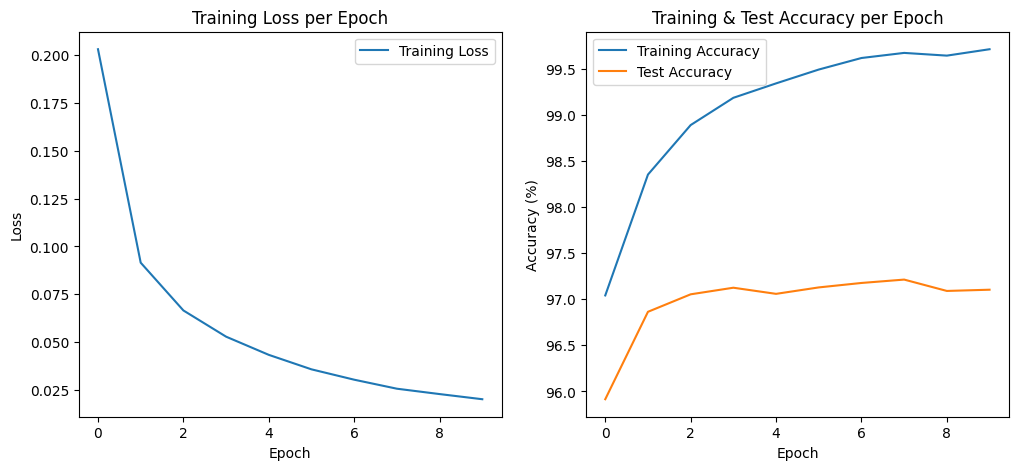

Epoch 10/10, Loss: 0.0201
Epoch 10/10, Training Accuracy: 99.72%
Epoch 10/10, Test Accuracy: 97.10%
Epoch 10/10, Training Time: 43.04 seconds
Total Training Time: 661.91 seconds
[47.57228398323059, 42.085593461990356, 43.444843769073486, 43.893969774246216, 44.3298704624176, 43.304222106933594, 43.25901985168457, 43.24539637565613, 44.628769636154175, 43.042765617370605]
the testing time:
[23.315566539764404, 21.67925238609314, 18.352511405944824, 30.911854028701782, 18.64192271232605, 17.849480628967285, 24.08975076675415, 20.67255449295044, 19.13630771636963, 27.21318531036377]


In [22]:
# training without L1 regularization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(dga_detector.parameters(), lr=0.001)
num_epochs = 10
batch_size = 150

# move model to device
dga_detector.to(device)

# init
loss_values = []  # loss value
train_acc = []  # train accuracy
test_acc = []  # test accuracy
epoch_training_time_list = []  # time list
total_start_time = time.time()  # Start time for the whole training process
epoch_testing_time_list = []
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time for each epoch
    
    dga_detector.train()  # training mode
    running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i + batch_size].to(device)
        batch_y = y_train[i:i + batch_size].to(device)
        src_mask = (batch_X != 0).to(device)  # create a mask(a vector) consist with 0/1 with the condition x != 0 -> True x == 0 -> False

        # feed forward
        output = dga_detector(batch_X, src_mask)

        # calculate CrossEntropyLoss expects batch_y as long type
        loss = loss_fn(output, batch_y.long())

        # clear the last gradient
        optimizer.zero_grad()

        # back propagation
        loss.backward()

        # update weight
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()

        # move batch data back to CPU to free CUDA memory
        # End of each batch iteration
        del batch_X, batch_y, src_mask, output
        torch.cuda.empty_cache()

        

    # calculate training accuracy
    train_accuracy = calculate_accuracy(dga_detector, X_train, y_train, device, batch_size)
    train_acc.append(train_accuracy)

    # calculate average loss
    avg_loss = running_loss / (len(X_train) / batch_size)
    loss_values.append(avg_loss)

    # test accuracy
    dga_detector.eval()
    all_y_test = []
    all_y_pred = []

    # Calculate epoch training time
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    epoch_training_time_list.append(epoch_training_time)

    # start calculating testing time
    testing_start_time = time.time()
    with torch.no_grad():
        for label in test_data_by_label.keys():
            data_list = test_data_by_label[label]
            X_test = []
            y_test = []
            for X, y in data_list:
                X_test.append(X)
                y_test.append(y)

            X_test = torch.tensor(X_test, dtype=torch.long).to(device)
            y_test = torch.tensor(y_test, dtype=torch.long).to(device)

            src_mask = (X_test != 0).to(device)

            output = dga_detector(X_test, src_mask)

            y_pred = torch.argmax(output, dim=1)

            all_y_test.extend(y_test.cpu().numpy())
            all_y_pred.extend(y_pred.cpu().numpy().flatten())

    # calcuatation
    testing_end_time = time.time()
    epoch_testing_time = testing_end_time - testing_start_time
    epoch_testing_time_list.append(epoch_testing_time)
    
    # overall accuracy
    overall_accuracy = accuracy_score(all_y_test, all_y_pred) * 100
    test_acc.append(overall_accuracy)


    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.title('Training & Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {overall_accuracy:.2f}%")
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Time: {epoch_training_time:.2f} seconds")

# Total training time
total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(epoch_training_time_list)

print("the testing time:")
print(epoch_testing_time_list)

In [23]:
tot_time = 0.0
for time in epoch_training_time_list:
    tot_time += time

print(tot_time)

438.8067350387573


In [24]:
# # training with L1 regularization

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(dga_detector.parameters(), lr=0.001)
# num_epochs = 10
# batch_size = 150
# l1_lambda = 0.001

# # move model to device
# dga_detector.to(device)

# # init
# loss_values = []  # loss value
# train_acc = []  # train accuracy
# test_acc = []  # test accuracy
# epoch_training_time_list = []  # time list
# total_start_time = time.time()  # Start time for the whole training process

# for epoch in range(num_epochs):
#     epoch_start_time = time.time()  # Start time for each epoch

#     dga_detector.train()  # training mode
#     running_loss = 0.0

#     for i in range(0, len(X_train), batch_size):
#         batch_X = X_train[i:i + batch_size].to(device)
#         batch_y = y_train[i:i + batch_size].to(device)
#         src_mask = (batch_X != 0).to(device)  # create a mask(a vector) consist with 0/1 with the condition x != 0 -> True x == 0 -> False

#         # feed forward
#         output = dga_detector(batch_X, src_mask)

#         # calculate CrossEntropyLoss expects batch_y as long type
#         loss = loss_fn(output, batch_y.long())

#         # calculate L1 regularization
#         l1_loss = 0
#         for name, param in dga_detector.named_parameters():
#             if 'weight' in name:
#                 l1_loss += torch.sum(torch.abs(param))

#         # add the L1 regularization term
#         loss += l1_lambda * l1_loss

#         # clear the last gradient
#         optimizer.zero_grad()

#         # back propagation
#         loss.backward()

#         # update weight
#         optimizer.step()

#         # accumulate loss
#         running_loss += loss.item()
        
#         # move batch data back to CPU to free CUDA memory
#         batch_X = batch_X.cpu()
#         batch_y = batch_y.cpu()
#         src_mask = src_mask.cpu()

#     # Calculate epoch training time
#     epoch_end_time = time.time()
#     epoch_training_time = epoch_end_time - epoch_start_time
#     epoch_training_time_list.append(epoch_training_time)

#     # calculate training accuracy
#     train_accuracy = calculate_accuracy(dga_detector, X_train, y_train, device, batch_size)
#     train_acc.append(train_accuracy)

#     # calculate average loss
#     avg_loss = running_loss / (len(X_train) / batch_size)
#     loss_values.append(avg_loss)

#     # test accuracy
#     dga_detector.eval()
#     all_y_test = []
#     all_y_pred = []

#     with torch.no_grad():
#         for label in test_data_by_label.keys():
#             data_list = test_data_by_label[label]
#             X_test = []
#             y_test = []
#             for X, y in data_list:
#                 X_test.append(X)
#                 y_test.append(y)

#             X_test = torch.tensor(X_test, dtype=torch.long).to(device)
#             y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#             src_mask = (X_test != 0).to(device)

#             output = dga_detector(X_test, src_mask)

#             y_pred = torch.argmax(output, dim=1)

#             all_y_test.extend(y_test.cpu().numpy())
#             all_y_pred.extend(y_pred.cpu().numpy().flatten())

#     # overall accuracy
#     overall_accuracy = accuracy_score(all_y_test, all_y_pred) * 100
#     test_acc.append(overall_accuracy)


#     # Plotting
#     clear_output(wait=True)
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.plot(loss_values, label='Training Loss')
#     plt.title('Training Loss per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(train_acc, label='Training Accuracy')
#     plt.plot(test_acc, label='Test Accuracy')
#     plt.title('Training & Test Accuracy per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy (%)')
#     plt.legend()

#     plt.show()

#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")
#     print(f"Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}%")
#     print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {overall_accuracy:.2f}%")
#     print(f"Epoch {epoch + 1}/{num_epochs}, Training Time: {epoch_training_time:.2f} seconds")

# # Total training time
# total_end_time = time.time()
# total_training_time = total_end_time - total_start_time
# print(f"Total Training Time: {total_training_time:.2f} seconds")
# print(epoch_training_time_list)


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time
label_accuracy = {}
all_labels = [0, 1, 2]  # we have 3 class
# currmulative result
all_y_test = []
all_y_pred = []

test_start_time = 0.0
test_start_time = time.time()  # Start time for the whole training process

for label in test_data_by_label.keys():
    data_list = test_data_by_label[label]
    X_test = []
    y_test = []
    for X, y in data_list:
        X_test.append(X)
        y_test.append(y)

    # convert it to tensor
    X_test = torch.tensor(X_test, dtype=torch.long).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    # evaluation mode
    dga_detector.eval()
    # turn off the gradient
    with torch.no_grad():
        src_mask = (X_test != 0).to(device)
        output = dga_detector(X_test, src_mask)

    # convert the predicted value with argmax to see which argument got the highest value
    y_pred = torch.argmax(output, dim=1)

    # append the result to overall
    all_y_test.extend(y_test.cpu().numpy())
    all_y_pred.extend(y_pred.cpu().numpy())

    # calculate all correct labels and overall accuracy for this label
    correct = (y_pred == y_test).sum().item()
    accuracy = correct / len(y_test) * 100
    label_accuracy[label] = accuracy

    # confusion matrix for this label
    print(f"Label: {label}, Accuracy: {accuracy:.2f}%")
    conf_matrix = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy(), labels=all_labels)
    print(f"Confusion Matrix for label {label}:")
    print(conf_matrix)


test_end_time = time.time()
testing_time = test_end_time - test_start_time
# overall performance
print("\nOverall Performance:")

# Overall Confusion Matrix
overall_conf_matrix = confusion_matrix(all_y_test, all_y_pred, labels=all_labels)
print("Overall Confusion Matrix:")
print(overall_conf_matrix)

# Overall Accuracy
overall_accuracy = accuracy_score(all_y_test, all_y_pred) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

# Classification Report
class_report = classification_report(all_y_test, all_y_pred, labels=all_labels)
print("Classification Report:")
print(class_report)

print("testing time:", testing_time, " seconds")

Label: normal.alexa, Accuracy: 95.13%
Confusion Matrix for label normal.alexa:
[[18933   683   286]
 [    0     0     0]
 [    0     0     0]]
Label: dga.matsnu, Accuracy: 99.84%
Confusion Matrix for label dga.matsnu:
[[    0     0     0]
 [    0     0     0]
 [   30     0 18244]]
Label: dga.necurs, Accuracy: 97.13%
Confusion Matrix for label dga.necurs:
[[  0   0   0]
 [ 26 879   0]
 [  0   0   0]]
Label: dga.pushdo, Accuracy: 87.82%
Confusion Matrix for label dga.pushdo:
[[  0   0   0]
 [123 887   0]
 [  0   0   0]]
Label: dga.suppobox, Accuracy: 98.85%
Confusion Matrix for label dga.suppobox:
[[   0    0    0]
 [   0    0    0]
 [  17    0 1462]]
Label: dga.virut, Accuracy: 59.85%
Confusion Matrix for label dga.virut:
[[ 0  0  0]
 [53 79  0]
 [ 0  0  0]]
Label: dga.ramdo, Accuracy: 99.16%
Confusion Matrix for label dga.ramdo:
[[   0    0    0]
 [   9 1062    0]
 [   0    0    0]]
Label: dga.murofet, Accuracy: 98.56%
Confusion Matrix for label dga.murofet:
[[  0   0   0]
 [  8 547   

In [26]:
# dga_detector.load_state_dict(torch.load('model/dga_detector_model(2-gram complicated model).pth', map_location=torch.device(device)))
# dga_detector.eval()
# print("Model weights loaded successfully on cuda")

In [27]:
# # Ensure all data is on the same device as the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move model to the correct device
# dga_detector.to(device)

# # Iterate through test data by label
# for label in test_data_by_label.keys():
#     data_list = test_data_by_label[label]
#     X_test = []
#     y_test = []
#     for X, y in data_list:
#         X_test.append(X)
#         y_test.append(y)

#     # Convert it to tensor and move to the correct device
#     X_test = torch.tensor(X_test, dtype=torch.long).to(device)
#     y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#     # Evaluation mode
#     dga_detector.eval()

#     # Turn off the gradient
#     with torch.no_grad():
#         src_mask = (X_test != 0).to(device)  # Ensure src_mask is also on the same device
#         output = dga_detector(X_test, src_mask)

#     # Convert the predicted value with argmax to see which argument got the highest value
#     y_pred = torch.argmax(output, dim=1)

#     # Append results to overall arrays
#     all_y_test.extend(y_test.cpu().numpy())
#     all_y_pred.extend(y_pred.cpu().numpy())

#     # Calculate accuracy for this label
#     correct = (y_pred == y_test).sum().item()
#     accuracy = correct / len(y_test) * 100
#     label_accuracy[label] = accuracy

#     # Confusion matrix for this label
#     print(f"Label: {label}, Accuracy: {accuracy:.2f}%")
#     conf_matrix = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy(), labels=all_labels)
#     print(f"Confusion Matrix for label {label}:")
#     print(conf_matrix)


In [28]:
import pickle

# Save the vocab
with open('tokenizer_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

torch.save(dga_detector.state_dict(), 'dga_detector_model.pth')
print("Model saved as 'dga_detector_model.pth'")

Model saved as 'dga_detector_model.pth'
